In [1]:
!pip install optuna -q

In [2]:
!pip install scikit-learn -q

In [8]:
import os
import torch
import numpy as np
import random
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
torch.cuda.is_available()

True

In [9]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.1
torchvision version: 0.17.1


In [10]:
torch.cuda.device_count()

1

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading Data

In [21]:
# Paths and configurations
DATA_DIR = '/app/data'
BATCH_SIZE = 16
CLASSES = ['control', 'CBFB_MYH11']
IMAGE_SIZE = (144, 144)

In [13]:
# Helper function to count files in directories
def count_files_in_directory(root_directory, target_folder):
    target_path = None
    for root, dirs, _ in os.walk(root_directory):
        if target_folder in dirs:
            target_path = os.path.join(root, target_folder)
            break
    if target_path:
        total_files = sum(len(files) for _, _, files in os.walk(target_path))
        print(f"Total number of files under the '{target_folder}' folder: {total_files}")
    else:
        print(f"No '{target_folder}' folder found.")

In [14]:
for cls in CLASSES:
    count_files_in_directory(DATA_DIR, cls)

Total number of files under the 'control' folder: 20305
Total number of files under the 'CBFB_MYH11' folder: 17212


In [15]:
# Dataset class for loading images
class CustomDataset(Dataset):
    def __init__(self, data_dir, classes, image_batch_size=3000, transform=None):
        self.transform = transform
        self.images, self.labels = self.load_images(data_dir, classes, image_batch_size)

    def load_images(self, data_dir, classes, image_batch_size):
        images, labels = [], []
        for idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            image_paths = [os.path.join(root, file) 
                           for root, _, files in os.walk(class_path) 
                           for file in files if file.endswith('.tif')]
            random.shuffle(image_paths)
            for img_path in image_paths[:image_batch_size]:
                with Image.open(img_path) as img:
                    images.append(np.array(img.convert('RGB')))
                    labels.append(idx)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx]) if self.transform else self.images[idx]
        return image, self.labels[idx]

In [16]:
# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

## Create and Split Dataset

In [18]:
dataset = CustomDataset(data_dir=DATA_DIR, classes=CLASSES, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
train_size -= val_size
test_size = len(dataset) - train_size - val_size
train_dataset, test_dataset = random_split(dataset, [train_size + val_size, test_size])
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Model

In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_layers, num_units, dropout_rate):
        super(CNNModel, self).__init__()
        layers = [nn.Conv2d(3, num_units, kernel_size=3, padding=1), nn.ReLU(),
                  nn.BatchNorm2d(num_units), nn.MaxPool2d(2)]
        
        for _ in range(num_layers - 1):
            layers.extend([nn.Conv2d(num_units, num_units * 2, kernel_size=3, padding=1),
                           nn.ReLU(), nn.BatchNorm2d(num_units * 2), nn.MaxPool2d(2)])
            num_units *= 2

        self.conv_layers = nn.Sequential(*layers)
        fc_input_size = num_units * (IMAGE_SIZE[0] // (2 ** num_layers)) * (IMAGE_SIZE[1] // (2 ** num_layers))
        self.fc1 = nn.Linear(fc_input_size, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv_layers(x).view(x.size(0), -1)
        return self.fc2(self.dropout(self.fc1(x)))

## Hyperparameter Tunning

In [25]:
EPOCHS = 15

In [23]:
def objective(trial):
    num_layers = trial.suggest_int("num_layers", 2, 3)
    num_units = trial.suggest_int("num_units", 128, 384, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)

    model = CNNModel(num_layers=num_layers, num_units=num_units, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    patience = 3
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for epoch in range(EPOCHS):
        model.train()
        train_loss = sum(criterion(model(inputs.to(device)), labels.to(device)).item() for inputs, labels in train_loader) / len(train_loader)
        val_loss = sum(criterion(model(inputs.to(device)), labels.to(device)).item() for inputs, labels in val_loader) / len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break
    return best_val_loss

In [26]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2024-11-09 14:26:10,748] A new study created in memory with name: no-name-3a6add03-2ea5-4f68-810c-47ae9abe7292
[I 2024-11-09 14:26:55,043] Trial 0 finished with value: 0.7367860343721178 and parameters: {'num_layers': 2, 'num_units': 256, 'dropout_rate': 0.1931975658024461, 'learning_rate': 0.0004973834326270402}. Best is trial 0 with value: 0.7367860343721178.
[I 2024-11-09 14:27:30,620] Trial 1 finished with value: 0.8337640444437663 and parameters: {'num_layers': 2, 'num_units': 128, 'dropout_rate': 0.26457316997581554, 'learning_rate': 0.00011045290386644114}. Best is trial 0 with value: 0.7367860343721178.
[I 2024-11-09 14:29:13,368] Trial 2 finished with value: 0.7264713101916843 and parameters: {'num_layers': 2, 'num_units': 256, 'dropout_rate': 0.023913785825759447, 'learning_rate': 0.00021123058987955045}. Best is trial 2 with value: 0.7264713101916843.
[I 2024-11-09 14:30:58,577] Trial 3 finished with value: 0.7347679946157667 and parameters: {'num_layers': 2, 'num_units':

In [27]:
best_params = study.best_params

print("  Hyperparameters: ")
for key, value in best_params.items():
    print(f"    {key}: {value}")

  Hyperparameters: 
    num_layers: 2
    num_units: 256
    dropout_rate: 0.023913785825759447
    learning_rate: 0.00021123058987955045


## Final Training with Best Hypermeters

In [28]:
best_model = CNNModel(
    num_layers=best_params['num_layers'],
    num_units=best_params['num_units'],
    dropout_rate=best_params['dropout_rate']
).to(device)

In [29]:
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

In [30]:
# Metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 50
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

In [31]:
for epoch in range(EPOCHS):
    # Training phase
    best_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    best_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

Epoch 1: Train Loss: 19.3576, Train Acc: 0.7689, Val Loss: 3.7767, Val Acc: 0.8069
Epoch 2: Train Loss: 1.5239, Train Acc: 0.8495, Val Loss: 1.6047, Val Acc: 0.7444
Epoch 3: Train Loss: 0.5749, Train Acc: 0.8640, Val Loss: 0.8824, Val Acc: 0.7792
Epoch 4: Train Loss: 0.2730, Train Acc: 0.9042, Val Loss: 0.5067, Val Acc: 0.8333
Epoch 5: Train Loss: 0.2249, Train Acc: 0.9159, Val Loss: 0.4991, Val Acc: 0.8472
Epoch 6: Train Loss: 0.2291, Train Acc: 0.9154, Val Loss: 0.5335, Val Acc: 0.8486
Epoch 7: Train Loss: 0.1856, Train Acc: 0.9319, Val Loss: 1.0758, Val Acc: 0.8042
Epoch 8: Train Loss: 0.2550, Train Acc: 0.9125, Val Loss: 0.6860, Val Acc: 0.8278
Early stopping triggered


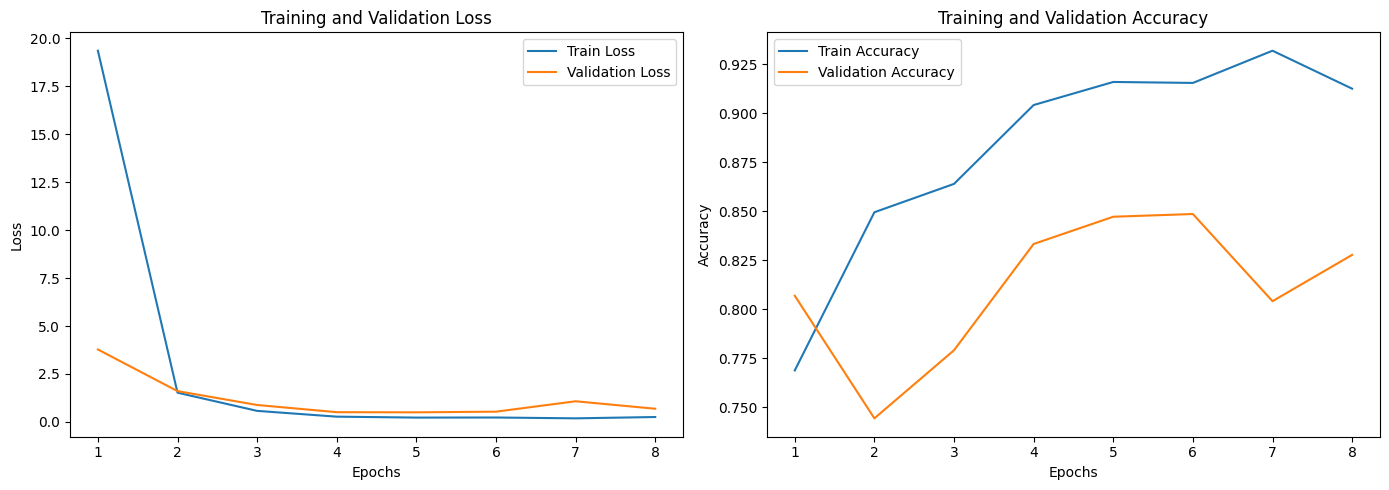

In [32]:
# Plot training and validation losses and accuracies
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [48]:
# Evaluate with test data

y_pred, y_true = [], []

def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            

In [49]:
evaluate_model(best_model, test_loader)

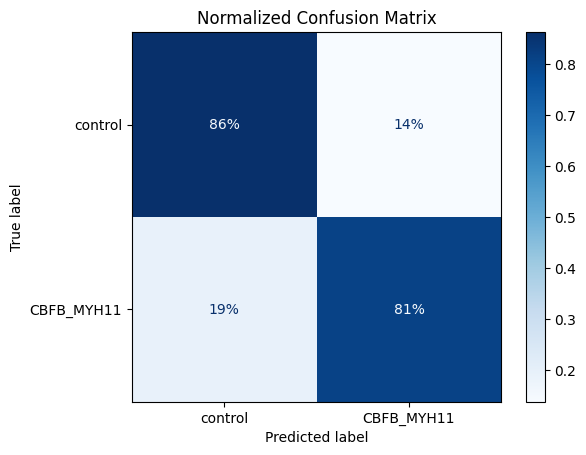

In [50]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true condition)

# Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=CLASSES)
disp.plot(cmap=plt.cm.Blues, values_format=".0%")
plt.title('Normalized Confusion Matrix')
plt.show()

In [51]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

     control       0.83      0.86      0.85       624
  CBFB_MYH11       0.84      0.81      0.83       576

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200

